# Superconducting qubits: improving measurement performance
**Using Q-CTRL discriminators and optimized measurement parameters to boost readout performance**

In superconducting qubit experiments, the problem of correctly identifying the state of a qubit as $\vert 0 \rangle $ (ground) or $\vert 1 \rangle$ (excited) corresponds to the problem of discriminating between different values of the $(I, Q)$ signal coming from the readout resonators. BOULDER OPAL provides you with customized discriminators that, together with a proper optimization of measurement pulse parameters, enable a significant reduction of readout errors. In this Application note, you'll first learn how to optimize the measurement pulse to give the best state differentiation when a Q-CTRL discriminator is used. You can then examine the improvement in visibility when this calibrated measurement pulse is used in a Rabi oscillation experiment. Next, you can learn to employ a Maximum Likelihood Estimation (MLE) method to further improve the visibility of Rabi oscillations to up to $0.99$.

*This notebook contains preview features that are not currently available in BOULDER OPAL. Please [contact us](https://q-ctrl.com/contact) if you want a live demonstration for your hardware. Preview features are included through the package `qctrlcore`, which is not publicly available: cells with `qctrlcore` will not be executable.*

*Some cells in this notebook require an account with IBM-Q to execute correctly. If you want to run them, please go to the [IBM-Q experience](https://quantum-computing.ibm.com/login) to set up an account.*

## Imports and initialization

In [12]:
import time
from pathlib import Path

# Choose to run experiments or to use saved data
use_IBM = False
if use_IBM:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    print("Time label for data saved throughout this experiment:" + timestr)
data_folder = Path(
    "resources/superconducting-qubits-improving-measurement-performance/"
)

import copy
import sys

import warnings

warnings.filterwarnings("ignore")

import pickle
from typing import Dict, List, Tuple

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from qctrlcore.cluster_metrics import get_best_measurement, intercluster_distance

# Q-CTRL imports
from qctrlcore.iq_discriminators import (
    create_gradient_boosting_discriminator,
    create_linear_discriminator,
    create_random_forest_discriminator,
)
from qctrlvisualizer import get_qctrl_style
from qctrlvisualizer.discriminators import plot_discriminator
from scipy import interpolate, stats
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

plt.style.use(get_qctrl_style())

# Q-CTRL auxiliary functions
def training_test_data(results, test_sample_size):
    """Randomly separate experiment results in a training and testing set for calibration and use of discriminators."""

    # Copy results object into a training object and a test object
    training_res = copy.deepcopy(results)
    test_res = copy.deepcopy(results)

    # Randomly select part of the results of for training/test of the discriminator
    (
        training_res.results[0].data.memory,
        test_res.results[0].data.memory,
    ) = train_test_split(results.results[0].data.memory, test_size=test_sample_size)
    (
        training_res.results[1].data.memory,
        test_res.results[1].data.memory,
    ) = train_test_split(results.results[1].data.memory, test_size=test_sample_size)

    return training_res, test_res


def calculate_avg_err(rabi_data):
    """Calculate average value and standard deviation of Rabi data."""
    rabi_data_avg = []
    rabi_data_err = []

    # Find average and standard deviation of Rabi data
    for i in range(len(rabi_data[0])):
        rabi_temp = []
        for j in range(len(rabi_data)):
            rabi_temp.append(rabi_data[j][i])

        # Calculate average of each data point
        rabi_data_avg.append(np.average(rabi_temp))

        # Calculate standard deviation
        rabi_data_err.append(
            np.sqrt(
                np.sum([(rabi_data_avg[i] - rabi) ** 2 for rabi in rabi_temp])
                / len(rabi_temp)
            )
        )

    return rabi_data_avg, rabi_data_err


def error_gamma(gamma, err_alpha, err_beta, err_f, alpha, beta):
    """Calculate error in the MLE estimation."""
    return (1 / (alpha - beta)) * np.sqrt(
        gamma ** 2 * err_alpha ** 2 + (gamma - 1) ** 2 * err_beta ** 2 + err_f ** 2
    )


def visibility(data):
    """Calculate the visibility of a sinusoidal signal."""
    I_max = np.max(data)
    I_min = np.min(data)
    return round((I_max - I_min) / (I_max + I_min), 2)


def ground_excited_experiment(qubit, backend, num_shots, measurement_schedule):
    """Run an experiment where the ground state is prepared and measured and the excited state is prepared and measured."""
    # Backend's default settings
    backend_defaults = backend.defaults()

    # Define default pi-pulse
    inst_sched_map = backend_defaults.instruction_schedule_map
    pi_default = inst_sched_map.get("x", qubits=backend_config.meas_map[meas_map_idx])

    # Create two schedules
    # Ground state schedule
    gnd_schedule = pulse.Schedule(name="cal_00")
    gnd_schedule += measurement_schedule

    # Excited state schedule
    exc_schedule = pulse.Schedule(name="cal_11")
    exc_schedule += pi_default
    exc_schedule += measurement_schedule << exc_schedule.duration

    # Assemble schedules into an experiment
    gnd_exc_program = assemble(
        [gnd_schedule, exc_schedule],
        backend=backend,
        meas_level=1,
        meas_return="single",
        shots=num_shots,
        schedule_los=[{drive_chan: backend_defaults.qubit_freq_est[qubit]}] * 2,
    )

    # Run
    job = backend.run(gnd_exc_program)
    job_monitor(job)
    gnd_exc_results = job.result(timeout=120)

    return gnd_exc_results


def train_discriminator(
    gnd_exc_results, test_sample, discriminator=create_gradient_boosting_discriminator
):
    """Train a given discriminator to recognize I/Q data corresponding to excited and ground state using the results obtained in a ground/excited state experiment."""

    # Calibrate discriminator on gnd/exc state experiment
    gnd_exc_training_results, gnd_exc_test_results = training_test_data(
        gnd_exc_results, test_sample
    )

    trained_discriminator = []
    trained_discriminator.append(
        discriminator(gnd_exc_training_results, [qubit], ["0", "1"])
    )

    # Collect ground state and excited state data to discriminate
    gnd_data = [data[0] for data in gnd_exc_test_results.results[0].data.memory]
    exc_data = [data[0] for data in gnd_exc_test_results.results[1].data.memory]

    # Store measurement result arrays for inter-cluster distance calculation in post-processing
    gnd_exc_data = np.concatenate((np.array(gnd_data), np.array(exc_data)))

    # Discriminate ground state data
    count_array = list(
        map(int, trained_discriminator[0].discriminate(gnd_data))
    )  # Turn the string of classified results into a list of integers 0 or 1
    probability_exc_gnd = np.sum(count_array) / len(
        count_array
    )  # To find probability of excited state, sum the elements of the count list (sum all the ones) and normalize by the number of elements
    probability_gnd_gnd = (
        1 - probability_exc_gnd
    )  # Find the probability of ground state

    # Discriminate excited state data
    count_array = list(map(int, trained_discriminator[0].discriminate(exc_data)))
    probability_exc_exc = np.sum(count_array) / len(count_array)
    probability_gnd_exc = 1 - probability_exc_exc

    return probability_exc_gnd, probability_exc_exc, gnd_exc_data, trained_discriminator


def rabi_experiment(
    qubit, backend, num_shots, measurement_schedule, measurement_setting
):
    """Run a Rabi experiment."""
    # Get qubit frequency
    qubit = 0
    backend.properties(refresh=True)
    qubit_frequency_updated = backend.properties().qubit_property(qubit, "frequency")[0]

    # Drive and measurement channels
    inst_sched_map = backend_defaults.instruction_schedule_map
    pi_default = inst_sched_map.get("x", qubits=backend_config.meas_map[qubit])

    # The minimum duration of a pulse in the armonk backend is 64*dt
    num_time_points = 50  # Number of points in the Rabi experiment
    pulse_amp = 0.4
    pulse_times = np.array(
        [
            64
            + np.arange(
                0,
                get_closest_multiple_of_16(16 * 2 * num_time_points),
                get_closest_multiple_of_16(16 * 2),
            )
        ]
    )

    rabi_schedules = []
    for integer_duration in pulse_times[0]:
        waveform = np.ones([integer_duration]) * pulse_amp
        this_schedule = pulse.Schedule(name=f"I pulse: duration = {integer_duration}")
        this_schedule += pulse.Play(pulse.Waveform(waveform), drive_chan)
        this_schedule += measurement_schedule << this_schedule.duration
        rabi_schedules.append(this_schedule)

    if measurement_setting == "calibrated":
        # Create two schedules
        # Excited state schedule
        exc_schedule = pulse.Schedule(name="cal_11")
        exc_schedule += pi_default
        exc_schedule += measurement_schedule

        # Ground state schedule
        gnd_schedule = pulse.Schedule(name="cal_00")
        gnd_schedule += measurement_schedule

        # Add calibration schedules to Rabi schedules
        rabi_schedules = [gnd_schedule] + [exc_schedule] + rabi_schedules

        # Assemble schedules in experiment
        rabi_experiment_program = assemble(
            rabi_schedules,
            backend=backend,
            meas_level=1,
            meas_return="single",
            shots=num_shots,
            schedule_los=[{drive_chan: qubit_frequency_updated}]
            * (len(pulse_times[0]) + 2),
        )
        # Run
        job = backend.run(rabi_experiment_program)
        job_monitor(job)
        rabi_results = job.result(timeout=120)
        return rabi_results

    elif measurement_setting == "default":
        # Assemble schedules in experiment
        rabi_experiment_program = assemble(
            rabi_schedules,
            backend=backend,
            meas_level=2,
            meas_return="avg",
            shots=num_shots,
            schedule_los=[{drive_chan: qubit_frequency_updated}]
            * (len(pulse_times[0])),
        )

        # Run
        job = backend.run(rabi_experiment_program)
        job_monitor(job)
        rabi_results = job.result(timeout=120)
        return rabi_results

    else:
        sys.exit("Select correct measurement setting: 'default' or 'calibrated' ")


# Parameters
GHz = 1.0e9  # Gigahertz
MHz = 1.0e6  # Megahertz
us = 1.0e-6  # Microseconds
ns = 1.0e-9  # Nanoseconds
runs = 16  # Number of runs for collecting statistics
num_shots = 1024  # Number of times each program is repeated
num_shots_with_training = 8 * num_shots
test_sample_size = 0.167  # Size of sample for testing of discriminators
num_time_points = 50  # Number of points in the Rabi experiment
colors = {"Calibrated": "#680CE9", "Default": "#000000"}

if use_IBM:
    # IBM-Q imports
    import qiskit.pulse as pulse
    import qiskit.pulse.pulse_lib as pulse_lib
    from qiskit import IBMQ
    from qiskit.compiler import assemble
    from qiskit.tools.jupyter import *
    from qiskit.tools.monitor import job_monitor

    # IBM credentials and backend selection
    IBMQ.enable_account("YOUR TOKEN HERE")
    provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
    backend = provider.get_backend("ibmq_armonk")
    backend_defaults = backend.defaults()
    backend_config = backend.configuration()
    assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

    # Backend properties
    qubit = 0
    qubit_freq_est = backend_defaults.qubit_freq_est[qubit]
    dt = backend_config.dt
    print(f"Qubit: {qubit}")
    print(f"Hardware sampling time: {dt/ns} ns")
    print(f"Qubit frequency estimate: {qubit_freq_est/GHz} GHz")

    # Set command channels
    drive_chan = pulse.DriveChannel(qubit)

    # Set measurement channels
    meas_chan = pulse.MeasureChannel(qubit)
    acq_chan = pulse.AcquireChannel(qubit)

    # Measurement map
    meas_map_idx = None
    for i, measure_group in enumerate(backend_config.meas_map):
        if qubit in measure_group:
            meas_map_idx = i
            break
    assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

else:
    qubit = 0
    dt = 2 / 9 * ns

# IBM-Q auxiliary functions
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) % 16)


def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

## Maximizing state differentiation with measurement tuning and Q-CTRL discriminators

In this section, you'll investigate the dependence of the performance of a $\vert 0 \rangle$ - $\vert 1 \rangle$ discrimination experiment on the controllable parameters of the measurement pulse: its amplitude and duration. For this purpose, state discrimination experiments are performed using a measurement pulse whose amplitude and duration are scanned over a certain range. The best values for these parameters are found by maximizing the distance between the two clusters formed by the $(I, Q)$ readout data, as larger inter-cluster distances allow for easier and more accurate state discrimination. Before the parameter scan, first observe a state discrimination experiment to visualize the readout data and the discriminators at work. This is done explicitly in the cell below.

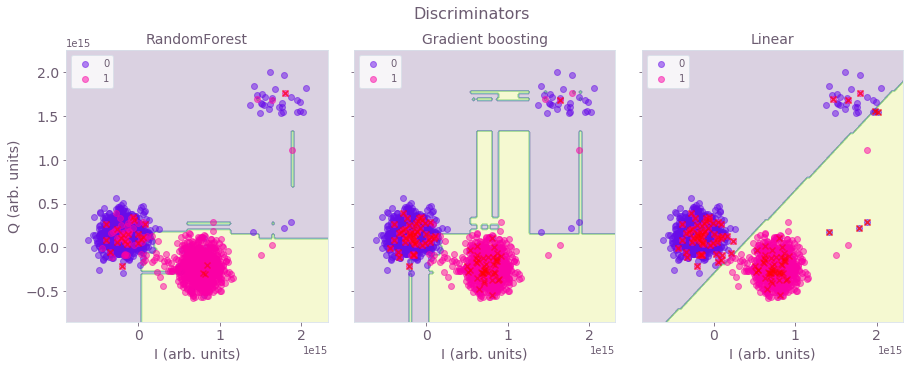

In [14]:
if use_IBM:
    # Use default measurement settings
    inst_sched_map = backend_defaults.instruction_schedule_map
    default_measure_schedule = inst_sched_map.get(
        "measure", qubits=backend_config.meas_map[meas_map_idx]
    )

    # Run experiment
    gnd_exc_experiment_result = ground_excited_experiment(
        qubit, backend, num_shots, default_measure_schedule
    )

    # Save data
    filename = "gnd_exc_experiment_result" + timestr
    outfile = open(filename, "wb")
    pickle.dump(gnd_exc_experiment_result, outfile)
    outfile.close()
else:
    # Load data
    filename = data_folder / "gnd_exc_experiment_result"
    infile = open(filename, "rb")
    gnd_exc_experiment_result = pickle.load(infile)
    infile.close()

# Discriminator used to classify data
discriminator_list = [
    create_random_forest_discriminator,
    create_gradient_boosting_discriminator,
    create_linear_discriminator,
]

discriminators = []

# Classify data
for disc in discriminator_list:
    discriminators.append(disc(gnd_exc_experiment_result, [qubit], ["0", "1"]))

# Plot result of the classification
gs = gridspec.GridSpec(1, 3, wspace=0.1)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
fig.suptitle("Discriminators", fontsize=16, y=1.0)
titles = ["RandomForest", "Gradient boosting", "Linear"]
for idx, disc in enumerate(discriminators):
    ax = fig.add_subplot(gs[idx])
    ax.tick_params(labelsize=14)
    plot_discriminator(
        disc, ax, flag_misclassified=True, show_boundary=True, title=False
    )
    ax.xaxis.label.set_fontsize(14)
    if idx == 0:
        ax.yaxis.label.set_fontsize(14)
    else:
        ax.yaxis.set_ticklabels([])
        ax.set_ylabel("")
    ax.set_title(titles[idx], fontsize=14)
plt.show()

In the figure, I/Q data points are displayed from each experiment shot, and the legend indicates whether the given point is a measurement of the ground or excited state. These known ground and excited state measurements are used to train different discriminators provided by Q-CTRL. The discriminators can then be used to classify future I/Q measurement data by their location in the I/Q plane. Above, three of these discriminators are shown: Random Forest, Gradient Boosting and Linear discriminators. The different-colored shaded regions illustrate the I/Q regions for different state classifications.

### Scan of measurement pulse parameters

Next, perform a scan over a range of amplitude and duration values of the measurement pulse to find the best pair of parameters. The optimal measurement pulse is the one where the state discrimination performance, as measured by the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), is maximized.

In [15]:
if use_IBM:
    # Parameters for amplitude scan
    measurement_amp_min = 0.05
    measurement_amp_max = 1
    measurement_amp_steps = 10
    measurement_amp_array = np.linspace(
        measurement_amp_min, measurement_amp_max, measurement_amp_steps
    )

    # Parameters for duration scan
    measurement_samples_min = 1
    measurement_samples_max = 4
    measurement_samples_steps = 15
    measurement_samples_array = np.linspace(
        measurement_samples_min, measurement_samples_max, measurement_samples_steps
    )

    measurement_data = []
    silhouette_list = []

    # Iterate over amplitude values
    for measurement_amp in measurement_amp_array:
        print("\nAMPLITUDE:", measurement_amp, " a.u.")

        silhouette_time_list = []
        # Iterate over duration values
        for measurement_samples_us in measurement_samples_array:
            ### Construct the measurement pulse
            # Measurement pulse parameters
            measurement_sigma_us = (
                0.5  # Width of the gaussian part of the rise and fall in us
            )
            measurement_risefall_us = 0.1  # Truncating parameter: how many samples to dedicate to the risefall

            # Convert to machine format
            measurement_sigma = get_closest_multiple_of_16(
                measurement_sigma_us * 1e-6 / dt
            )
            measurement_risefall = get_closest_multiple_of_16(
                measurement_risefall_us * 1e-6 / dt
            )
            measurement_samples = get_closest_multiple_of_16(
                measurement_samples_us * 1e-6 / dt
            )
            print("DURATION:", measurement_samples_us, " a.u.")

            # Define measurement pulse
            measurement_pulse = pulse_lib.gaussian_square(
                duration=measurement_samples,
                sigma=measurement_sigma,
                amp=measurement_amp,
                risefall=measurement_risefall,
                name="measurement_pulse",
            )

            # Import backend configurations
            backend_config = backend.configuration()

            # Set measurement channels
            meas_chan = pulse.MeasureChannel(qubit)
            acq_chan = pulse.AcquireChannel(qubit)

            # Add a measurement stimulus on the measure channel pulse to trigger readout
            measure_schedule = pulse.Play(measurement_pulse, meas_chan)

            # Trigger data acquisition, and store measured values into respective memory slots
            measure_schedule += pulse.Acquire(
                measurement_pulse.duration,
                pulse.AcquireChannel(backend_config.meas_map[meas_map_idx][0]),
                pulse.MemorySlot(backend_config.meas_map[meas_map_idx][0]),
            )

            # Run 0-1 state discrimination experiment
            gnd_exc_experiment_result = ground_excited_experiment(
                qubit, backend, num_shots_with_training, measure_schedule
            )

            # Train and classify data with Q-CTRL's discriminator
            gnd_exc_results = train_discriminator(
                gnd_exc_experiment_result, test_sample_size
            )[2]

            # Store results
            measurement_data.append(gnd_exc_results)
            silhouette_time_list.append(intercluster_distance(gnd_exc_results))

        silhouette_list.append(silhouette_time_list)

    # Save data
    filename = "measurement_amplitude_array" + timestr
    outfile = open(filename, "wb")
    pickle.dump(measurement_amp_array, outfile)
    outfile.close()
    filename = "measurement_samples_array" + timestr
    outfile = open(filename, "wb")
    pickle.dump(measurement_samples_array, outfile)
    outfile.close()
    filename = "measurements" + timestr
    outfile = open(filename, "wb")
    pickle.dump(measurement_data, outfile)
    outfile.close()
    filename = "silhouette_list" + timestr
    outfile = open(filename, "wb")
    pickle.dump(silhouette_list, outfile)
    outfile.close()
else:
    # Load data
    filename = data_folder / "measurement_amplitude_array"
    infile = open(filename, "rb")
    measurement_amp_array = pickle.load(infile)
    infile.close()
    filename = data_folder / "measurement_samples_array"
    infile = open(filename, "rb")
    measurement_samples_array = pickle.load(infile)
    infile.close()
    filename = data_folder / "measurements"
    infile = open(filename, "rb")
    measurement_data = pickle.load(infile)
    infile.close()
    filename = data_folder / "silhouette_list"
    infile = open(filename, "rb")
    silhouette_list = pickle.load(infile)
    infile.close()

The silhouette score quantifies how well-defined the two clusters (corresponding to the $\vert 0 \rangle$ and $\vert 1 \rangle$ state) are by measuring the the inter-cluster and intra-cluster distance of each point. Below, you can observe a few examples of different silhouette scores, along with a depiction of the corresponding data.

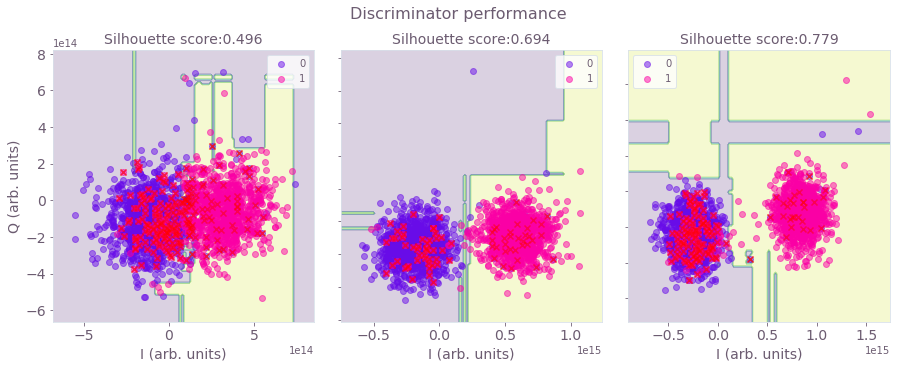

In [17]:
silhouette_scores_example = []
discriminated_data = []
idx_measurements = [40, 70, 143]  # Example of measurement results

for idx_measurement in idx_measurements:
    # Find silhouette score of a given measurement data
    x_idx = int(idx_measurement % len(measurement_samples_array))
    y_idx = int(idx_measurement / len(measurement_samples_array))

    # Make Result object from measurement data
    silhouette_score_result = copy.deepcopy(gnd_exc_experiment_result)
    data_idx = int(len(gnd_exc_experiment_result.results[0].data.memory))
    exc_data_idx = int(len(measurement_data[idx_measurement]) / 2)
    silhouette_score_result.results[0].data.memory = [
        [sample] for sample in (measurement_data[idx_measurement][:data_idx]).tolist()
    ]
    silhouette_score_result.results[1].data.memory = [
        [sample]
        for sample in (
            measurement_data[idx_measurement][exc_data_idx : exc_data_idx + data_idx]
        ).tolist()
    ]

    # Classify data
    discriminated_data.append(
        create_gradient_boosting_discriminator(
            silhouette_score_result, [qubit], ["0", "1"]
        )
    )

    # Get silhouette score
    silhouette_scores_example.append(round(silhouette_list[y_idx][x_idx], 3))

# Plot result of the classification
gs = gridspec.GridSpec(1, 3, wspace=0.1)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
fig.suptitle("Discriminator performance", fontsize=16, y=1.0)
for idx, data in enumerate(discriminated_data):
    ax = fig.add_subplot(gs[idx])
    ax.tick_params(labelsize=14)
    plot_discriminator(
        data, ax, flag_misclassified=True, show_boundary=True, title=False
    )
    ax.xaxis.label.set_fontsize(14)
    if idx == 0:
        ax.yaxis.label.set_fontsize(14)
    else:
        ax.yaxis.set_ticklabels([])
        ax.set_ylabel("")
    ax.set_title("Silhouette score:%s" % silhouette_scores_example[idx], fontsize=14)
plt.show()

Next, you can visualize the silhouette score landscape as a function of the measurement parameters, using the results of the above parameter scan.

Best duration:  2.7142857142857144
Best amplitude:  1.0


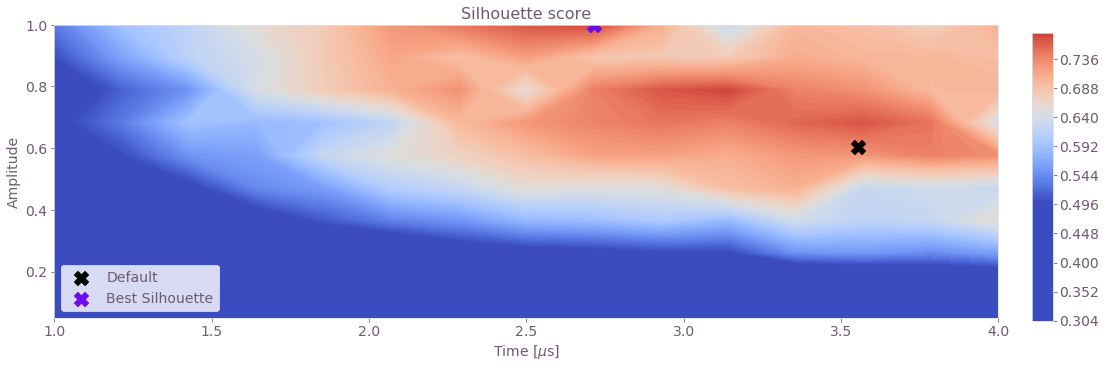

In [19]:
# Evaluate all measurements to determine which gives the best silhoutte score
gnd_exc_data, idx = (
    get_best_measurement(measurement_data)["measurement"],
    get_best_measurement(measurement_data)["index"],
)

# Find duration and amplitude of best measurement results
dur_idx = int(idx % len(measurement_samples_array))
amp_idx = int(idx / len(measurement_samples_array))

measurement_duration = measurement_samples_array[dur_idx]
measurement_amp = measurement_amp_array[amp_idx]

print("Best duration: ", measurement_duration)
print("Best amplitude: ", measurement_amp)

# Plot landscape of probability of excited state
fig, ax = plt.subplots(1, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(14)

Y = measurement_amp_array
X = measurement_samples_array
X, Y = np.meshgrid(X, Y)
Z0 = silhouette_list

cs = ax.contourf(
    X,
    Y,
    Z0,
    len(measurement_amp_array) * len(measurement_samples_array),
    cmap="coolwarm",
    vmin=0.5,
    vmax=0.8,
)

ax.set_ylabel("Amplitude", fontsize=14, rotation=90)
ax.set_xlabel(r"Time [$\mu$s]", fontsize=14, rotation=0)
ax.set_title("Silhouette score", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=14)

cb_ax = fig.add_axes([1.02, 0.12, 0.02, 0.8])
cbar1 = fig.colorbar(cs, cax=cb_ax, orientation="vertical")
cbar1.ax.tick_params(labelsize=14)

# Mark the value of the default setting and the best value from the scan
if use_IBM:
    backend_defaults = backend.defaults()
    backend_config = backend.configuration()
    inst_sched_map = backend_defaults.instruction_schedule_map
    default_measure_schedule = inst_sched_map.get(
        "measure", qubits=backend_config.meas_map[meas_map_idx]
    )  # measurement pulse parameters for default measurement
    default_amplitude = np.real(default_measure_schedule.instructions[1][1].pulse.amp)
    default_duration = default_measure_schedule.duration * dt / us
else:
    default_amplitude = 0.605
    default_duration = 3.556

ax.autoscale(False)  # Avoid scatterplot changing the plot limits
ax.scatter(
    default_duration,
    default_amplitude,
    color=colors["Default"],
    marker="X",
    s=200,
    zorder=1,
    label="Default",
)
ax.scatter(
    measurement_duration,
    measurement_amp,
    color=colors["Calibrated"],
    marker="X",
    s=200,
    zorder=1,
    label="Best Silhouette",
)
ax.legend(loc="lower left", fontsize=14)

plt.show()

The contour plot displays the silhouette score for different measurement parameters. The parameters for the default measurement pulse are marked with a black cross. The set of parameters corresponding to the best measurement pulse from the scan is marked with a purple cross.

### Rabi experiment

A Rabi oscillation experiment is ideal to observe the effect of the measurement optimization in the qubit readout performance. In the experiment, a qubit initially in the $\vert 0 \rangle$ state is driven resonantly so that its state oscillates between $\vert 0 \rangle$ and $\vert 1 \rangle$ as time evolves. Here, compare the results of the Rabi experiment obtained with the default measurement pulse and discriminator with the ones obtained using the calibrated measurement pulse and the Q-CTRL Gradient Boosting discriminator.

In [20]:
if use_IBM:
    # Measurement pulse parameters
    measurement_duration_us = measurement_samples_array[dur_idx]
    measurement_amp = measurement_amp_array[amp_idx]
    measurement_sigma_us = 0.5  # Width of the gaussian part of the rise and fall in us
    measurement_risefall_us = (
        0.1  # Truncating parameter: how many samples to dedicate to the risefall
    )

    # Convert to machine format
    measurement_sigma = get_closest_multiple_of_16(measurement_sigma_us * 1e-6 / dt)
    measurement_risefall = get_closest_multiple_of_16(
        measurement_risefall_us * 1e-6 / dt
    )
    measurement_duration = get_closest_multiple_of_16(
        measurement_duration_us * 1e-6 / dt
    )

    # Define measurement pulse
    calibrated_measurement_pulse = pulse_lib.gaussian_square(
        duration=measurement_duration,
        sigma=measurement_sigma,
        amp=measurement_amp,
        risefall=measurement_risefall,
        name="measurement_pulse",
    )

    # Add a measurement stimulus on the measure channel pulse to trigger readout
    calibrated_measure_schedule = pulse.Play(calibrated_measurement_pulse, meas_chan)

    # Trigger data acquisition, and store measured values into respective memory slots
    calibrated_measure_schedule += pulse.Acquire(
        calibrated_measurement_pulse.duration,
        pulse.AcquireChannel(backend_config.meas_map[meas_map_idx][0]),
        pulse.MemorySlot(backend_config.meas_map[meas_map_idx][0]),
    )

    # Run Rabi experiment with calibrated measurement pulse
    rabi_calibrated_result_list = [
        rabi_experiment(
            qubit, backend, num_shots, calibrated_measure_schedule, "calibrated"
        )
        for i in range(runs)
    ]

    # Discriminate Rabi data
    rabi_discriminated_list = []
    calibrated_probability_gnd = []
    calibrated_probability_exc = []
    for k in range(len(rabi_calibrated_result_list)):
        # Train the discriminator with a gnd/exc experiment done before the Rabi experiment and collect probabilities
        prob_exc_gnd, prob_exc_exc, data, trained_disc = train_discriminator(
            rabi_calibrated_result_list[k], test_sample_size
        )
        calibrated_probability_gnd.append(1 - prob_exc_gnd)
        calibrated_probability_exc.append(prob_exc_exc)

        # Discriminate each experiment
        rabi_discriminated = []
        for j in range(2, len(rabi_calibrated_result_list[0].results)):
            rabi = [
                data[0]
                for data in rabi_calibrated_result_list[k].results[j].data.memory
            ]
            count_array = list(
                map(int, trained_disc[0].discriminate(rabi))
            )  # Turn the string of classified results into a list of integers 0 or 1
            probability_exc = np.sum(count_array) / len(
                count_array
            )  # To find probability of excited state, sum the elements of the count list (sum all the ones) and normalize by the number of elements
            probability_gnd = (
                1 - probability_exc
            )  # Find the probability of ground state

            rabi_discriminated.append(probability_gnd)
        rabi_discriminated_list.append(rabi_discriminated)

    # Run Rabi experiment with default measurement pulse
    rabi_default_result_list = [
        rabi_experiment(qubit, backend, num_shots, default_measure_schedule, "default")
        for i in range(runs)
    ]

    # Discriminate Rabi data
    rabi_default_list = []
    for i in range(len(rabi_default_result_list)):
        rabi_discriminated = []
        for j in range(len(rabi_default_result_list[0].results)):
            rabi_discriminated.append(
                rabi_default_result_list[i].to_dict()["results"][j]["data"]["counts"][
                    "0x0"
                ]
                / num_shots
            )
        rabi_default_list.append(rabi_discriminated)

    # Save data
    filename = "rabi_discriminated_list" + timestr
    outfile = open(filename, "wb")
    pickle.dump(rabi_discriminated_list, outfile)
    outfile.close()
    filename = "probability_ground_calibrated" + timestr
    outfile = open(filename, "wb")
    pickle.dump(calibrated_probability_gnd, outfile)
    outfile.close()
    filename = "probability_excited_calibrated" + timestr
    outfile = open(filename, "wb")
    pickle.dump(calibrated_probability_exc, outfile)
    outfile.close()
    filename = "rabi_default_list" + timestr
    outfile = open(filename, "wb")
    pickle.dump(rabi_default_list, outfile)
    outfile.close()
else:
    # Load data
    filename = data_folder / "rabi_discriminated_list"
    infile = open(filename, "rb")
    rabi_discriminated_list = pickle.load(infile)
    infile.close()
    filename = data_folder / "probability_ground_calibrated"
    infile = open(filename, "rb")
    calibrated_probability_gnd = pickle.load(infile)
    infile.close()
    filename = data_folder / "probability_excited_calibrated"
    infile = open(filename, "rb")
    calibrated_probability_exc = pickle.load(infile)
    infile.close()
    filename = data_folder / "rabi_default_list"
    infile = open(filename, "rb")
    rabi_default_list = pickle.load(infile)
    infile.close()

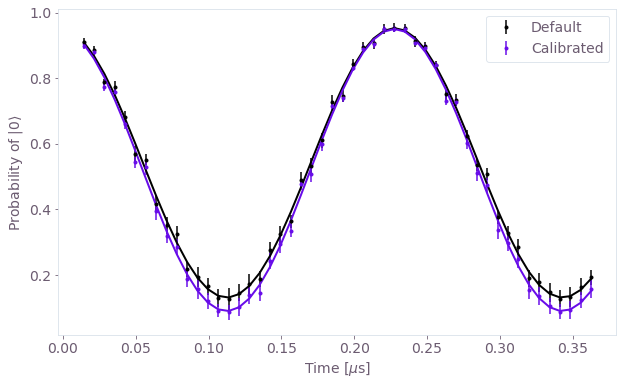

The visibility of the Rabi oscillations obtained with the default setting is:  0.76
The visibility of the Rabi oscillations obtained with the optimal setting is:  0.83


In [28]:
# Calculate average Rabi data and deviation, excluding outliers
rabi_cal_avg, rabi_cal_err = calculate_avg_err(rabi_discriminated_list)
rabi_def_avg, rabi_def_err = calculate_avg_err(rabi_default_list)

# Drive duration values
pulse_times = np.array(
    [
        64
        + np.arange(
            0,
            get_closest_multiple_of_16(16 * 2 * num_time_points),
            get_closest_multiple_of_16(16 * 2),
        )
    ]
)
time_array = pulse_times[0] * dt / us


# Fit cosine function to the data
fit_params_def, y_fit_def = fit_function(
    time_array,
    rabi_def_avg,
    lambda x, A, B, drive_period, phi: (
        A * np.cos(2 * np.pi * x / drive_period - phi) + B
    ),
    [0.5, 0.5, 3 * 10 ** -1, 0],
)

# Fit a sinusoind to the data
fit_params_cal, y_fit_cal = fit_function(
    time_array,
    rabi_cal_avg,
    lambda x, A, B, drive_period, phi: (
        A * np.cos(2 * np.pi * x / drive_period - phi) + B
    ),
    [0.5, 0.5, 3 * 10 ** -1, 0],
)
# Plot
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax.plot(time_array, y_fit_def, color=colors["Default"], linewidth=2)
ax.errorbar(
    time_array,
    rabi_def_avg,
    yerr=rabi_def_err,
    color=colors["Default"],
    fmt=".",
    label="Default",
    markersize=6,
)

ax.plot(time_array, y_fit_cal, color=colors["Calibrated"], linewidth=2)
ax.errorbar(
    time_array,
    rabi_cal_avg,
    yerr=rabi_cal_err,
    color=colors["Calibrated"],
    fmt=".",
    label="Calibrated",
    markersize=6,
)

plt.xlabel("Time [$\mu$s]", fontsize=14)
plt.ylabel(r"Probability of $\vert 0 \rangle$ ", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.legend(fontsize=14)
plt.show()

print(
    "The visibility of the Rabi oscillations obtained with the default setting is: ",
    visibility(y_fit_def),
)
print(
    "The visibility of the Rabi oscillations obtained with the optimal setting is: ",
    visibility(y_fit_cal),
)

The results obtained for the Rabi experiment with Q-CTRL's optimal settings show an improvement over the ones that are obtained using the default settings. This demonstrates that you can use Q-CTRL's capabilities to successfully calibrate a measurement pulse without specific knowledge of the underlying system.

## Improving Rabi oscillation contrast using Maximum Likelihood Estimation (MLE)

In the following, you'll learn how to use Maximum Likelihood Estimation to improve the contrast in Rabi oscillations obtained with a Q-CTRL calibrated measurement pulse and discriminator.

The state estimation quality can be boosted by measuring the false positive ($\alpha$) and negative ($1 - \beta$) state identification probabilities and incorporating this information into a Maximum Likelihood Estimation. Assume the following likelihood function for the measurement process, which is modeled as correlated coin tosses of biased coins:

$$ L\left( \alpha, \beta, \gamma  ; \{F_2\} \right)  =  \left[ \alpha \gamma + \beta (1-\gamma) \right]^{N - \sum_{i=1}^N F_{2i}} \left[ (1 - \alpha) \gamma + (1-\beta) (1-\gamma) \right]^{\sum_{i=1}^N F_{2i}} ,$$

where $\gamma$ is the actual probability that the qubit state is $\vert 0 \rangle$ and $F_{2i} = 0, 1$ is the outcome of the measurement in one instance of the experiment. The likelihood can be maximized analytically to give:

$$  \gamma =  \frac{(1-\beta ) - \frac{\sum_{i=1}^N F_{2i}}{N}}{\alpha - \beta} .$$

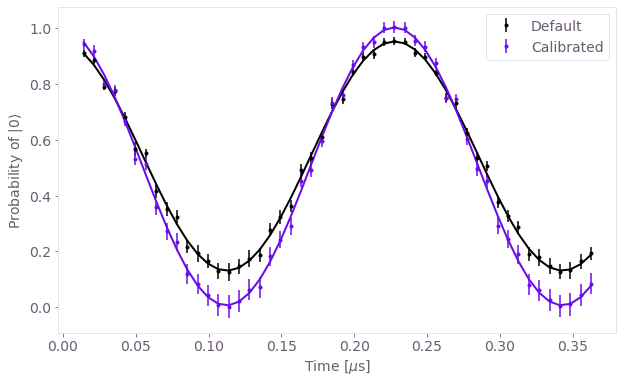

The visibility of the Rabi oscillations obtained with the default settings is:  0.76
The visibility of the Rabi oscillations obtained with the optimal settings and MLE is:  0.99


In [29]:
# Find average values of \alpha and \beta and their deviation
avg_probability_gnd = np.average(calibrated_probability_gnd)
deviation_probability_gnd = np.sqrt(
    np.sum([(avg_probability_gnd - prob) ** 2 for prob in calibrated_probability_gnd])
    / len(calibrated_probability_gnd)
)
avg_probability_exc = np.average(calibrated_probability_exc)
deviation_probability_exc = np.sqrt(
    np.sum([(avg_probability_exc - prob) ** 2 for prob in calibrated_probability_exc])
    / len(calibrated_probability_exc)
)

# Written in terms of the variable of the theoretical model
alpha = avg_probability_gnd
beta = 1 - avg_probability_exc

# Calculate estimate of probability of ground state
gamma_list = []
for i in range(num_time_points):
    gamma_list.append(((1 - beta) - (1 - rabi_cal_avg[i])) / (alpha - beta))

# Calculate the error on the MLE estimate
err_gamma = []
for i, gamma in enumerate(gamma_list):
    err_gamma.append(
        error_gamma(
            gamma,
            deviation_probability_gnd,
            deviation_probability_exc,
            np.sqrt((rabi_cal_avg[i] * (1 - rabi_cal_avg[i])) / (runs * num_shots)),
            alpha,
            beta,
        )
    )

# Fit a sinusoind to the MLE data
fit_params_gamma, y_fit_gamma = fit_function(
    time_array,
    gamma_list,
    lambda x, A, B, drive_period, phi: (
        A * np.cos(2 * np.pi * x / drive_period - phi) + B
    ),
    [0.5, 0.5, 3 * 10 ** -1, 0],
)
# Plot
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax.plot(time_array, y_fit_def, color=colors["Default"], linewidth=2)
ax.errorbar(
    time_array,
    rabi_def_avg,
    yerr=rabi_def_err,
    color=colors["Default"],
    fmt=".",
    label="Default",
    markersize=6,
)

ax.plot(time_array, y_fit_gamma, color=colors["Calibrated"], linewidth=2)
ax.errorbar(
    time_array,
    gamma_list,
    yerr=err_gamma,
    color=colors["Calibrated"],
    fmt=".",
    label="Calibrated",
    markersize=6,
)

plt.xlabel("Time [$\mu$s]", fontsize=14)
plt.ylabel(r"Probability of $\vert 0 \rangle$ ", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.legend(fontsize=14)
plt.show()

print(
    "The visibility of the Rabi oscillations obtained with the default settings is: ",
    visibility(y_fit_def),
)
print(
    "The visibility of the Rabi oscillations obtained with the optimal settings and MLE is: ",
    visibility(y_fit_gamma),
)

Overall, the use of the calibrated measurement pulse together with Maximum Likelihood Estimation of the qubit state gives an impressive improvement over the results obtained with the default settings.